# Data 608 Final Project
## created by Gaurav Kumar and Rupal Gandhi - Team 4

This notebook runs on talc.ucalgary.ca

## Introduction
* ### GitHub is a web-based version control repository with a robust collaboration mechanism.
* ### It has more than 40 million users and around 100 million repositories.
* ### It gives a good estimate of trending programming language and library.

## Data
* ### This is an open data github_repos at Google Bigquery public data.
* ### Table commits 774.07 GB with 237,161,297 rows
* ### Table contents 2.25 TB with 263,975,088 rows
* ### Table files 319.43 GB with 2,299,277,223 rows


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
import re

import os, atexit, sys, findspark, sparkhpc, pyspark, urllib
from pyspark.context import SparkContext
import pyspark.sql.functions as F
from pyspark.sql import SQLContext
from pyspark.sql.functions import udf
from pyspark.sql.functions import desc
from pyspark.sql.types import ArrayType
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import split, explode

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

## Part 0 
* ### start Spark and get spark context
The code below starts a spark cluster on TALC cluster.

In [2]:
try: sc.stop()
except: pass
try: sj.stop()
except: pass
! scancel -u `whoami` -n sparkcluster

findspark.init()

# specify your partition (unless you're OK with default)
os.environ['SBATCH_PARTITION']='cpu24'

sj = sparkhpc.sparkjob.sparkjob(
    ncores = 10,                       # total number or cores
    cores_per_executor = 2,            # parallelism of a single executor
    memory_per_core = 10240,           # memory per core in MB 
    walltime = "4:0"                   # hh:mm format
)

sj.wait_to_start()
sc = sj.start_spark()
scq = SQLContext(sc)

def exitHandler(sj,sc):
    try:
        print('Trapped Exit cleaning up Spark Context')
        sc.stop()
    except:
        pass
    try:
        print('Trapped Exit cleaning up Spark Job')
        sj.stop()
    except:
        pass
atexit.register(exitHandler,sj,sc);
display(sc)

INFO:sparkhpc.sparkjob:Submitted batch job 8329

INFO:sparkhpc.sparkjob:Submitted cluster 0


<SparkContext master=spark://b09:7077 appName=pyspark-shell>

## Part 1
* ### Load data into csv using BigQuery


### 1.1 Query to load commit table
* #### We approached breaking down data and querying data based on commit time
* #### Commit time is in ctime_sec column, ctime_sec is in UNIX time format.
* #### Break down data in 12 parts, 2000 to 2009, 2010 to 2011 and so on.
* #### Loaded data in local memory and writing to csv files
* #### There is huge amount of data, we are only querying fields based on scope of this project. 
* #### Below are fields we are focusing.
   * ##### message: message entered when committing code to repository
   * ##### repo_name: repository name where code is committed
   * ##### author.name: name of author of code (author and committer are same or different)
   * ##### author.time_sec: time_sec of author
   * ##### committer.name: name of committer of code
   * ##### ctime_sec: time_sec of committer when committing code
   * ##### key: identifier
   * ##### value: 

Note: 
- This step require setting up google client and environment variabale. without this setup code may not work properly.
- We have downloaded csv files to our local system and uploaded .csv files to U of C TALC. Code in next step uses .csv files uploaded on TALC.

In [ ]:
from google.cloud import bigquery
import pandas as pd

t_start=[978307199,1262304000,1293840000,1325376000,1356998400,1388534400,1420070400,1451606400,1483228800,1514764800,1546300800,1577836800]
t_end=[1262303999,1293839999,1325375999,1356998399,1388534399,1420070399,1451606399,1483228799,1514764799,1546300799,1577836799,1609459199]
for t_s, t_e in zip(t_start,t_end):

    if os.path.exists(f"github_commit_{t_s}.csv"): 
        print("Skipping execution of BigQuery")
    else:
        print("Executing BigQuer to load data and save as csv")        
        client = bigquery.Client()

        QUERY = """
                SELECT t1.message, t1.repo_name, t1.author.name, t1.author.time_sec, t1.committer.name as cname, t1.committer.time_sec as ctime_sec, h.key, h.value
            FROM `bigquery-public-data.github_repos.commits` AS t1, UNNEST(t1.trailer) as h
            WHERE t1.committer.time_sec >= @t_s AND t1.committer.time_sec <= @t_e
                """
        query_params = [
        bigquery.ScalarQueryParameter('t_s', 'INT64', t_s),
        bigquery.ScalarQueryParameter('t_e', 'INT64', t_e)
        ]
        job_config = bigquery.QueryJobConfig()
        job_config.query_parameters = query_params


        query_job = client.query(QUERY,job_config=job_config)

        iter1 = query_job.result(timeout=30)
        rows = list(iter1)

        commits = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
        commits.to_csv(f"github_commit_{t_s}.csv",sep=',', index=False)
        # Look at the first 10 headlines
        commits.head(10)
        del commits


### 1.2 Query to load language table

* #### This step query language table and create github_languages.csv
* #### We are first checking if table is available or not, if available we will skip executing BigQuery

In [ ]:
if os.path.exists("github_languages.csv"): 
    print("Skipping execution of BigQuery")
else:
    print("Executing BigQuer to load data and save as csv")
    QUERY_2 = """
            SELECT t1.repo_name, h.name, h.bytes
            FROM `bigquery-public-data.github_repos.languages` AS t1, UNNEST(t1.language) as h
            """
    query_job_2 = client.query(QUERY_2)

    iter_2 = query_job_2.result(timeout=100)
    rows_2 = list(iter_2)

    commits_2 = pd.DataFrame(data=[list(x.values()) for x in rows_2], columns=list(rows_2[0].keys()))
    commits_2.to_csv("github_languages.csv")
    commits_2.head(10)

### 1.3 Query to load license table
* #### This step query licenses table and create github_licenses.csv
* #### We are first checking if csv is already available or not, if available we will skip executing BigQuery

In [ ]:
if os.path.exists("github_licenses.csv"): 
    print("Skipping execution of BigQuery")
else:
    print("Executing BigQuer to load data and save as csv")
    QUERY_3 = """
            SELECT t1.repo_name, t1.license
            FROM `bigquery-public-data.github_repos.licenses` AS t1
            """
    query_job_3 = client.query(QUERY_3)

    iter_3 = query_job_3.result(timeout=100)
    rows_3 = list(iter_3)

    commits_3 = pd.DataFrame(data=[list(x.values()) for x in rows_3], columns=list(rows_3[0].keys()))
    commits_3.to_csv("github_licenses.csv")
    commits_3.head(10)

In [3]:
df1 = pd.read_csv('github_languages.csv')
df2 = pd.read_csv('github_licenses.csv')
df1 =df1.drop('Unnamed: 0', axis=1)
df2 =df2.drop('Unnamed: 0', axis=1)

## Part 2
* ### We are performing below steps for writting data to parquet file
    * #### Download each CSV file from remote location (TALC server).
    * #### Load the CSV file into a spark DataFrame.
    * #### Creating parquet file with snappy compression. 
    * #### Using append to adding next csv file in existing parquet file.

In [4]:
from pyspark.sql.types import *
from pyspark.sql import functions as F
list1=[978307199,1262304000,1293840000,1325376000,1356998400,1388534400,1420070400,1451606400,1483228800,1514764800,1546300800,1577836800]
r_cnt=0
LOCAL_PARQUET_FNAME = "github_commit.parquet.snappy"
LOCAL_CSV_FNAME = "github_commit_978307199.csv"
skip_parquet = False
if os.path.exists(LOCAL_PARQUET_FNAME):
    csvtime = os.path.getmtime(LOCAL_CSV_FNAME)
    pqttime = os.path.getmtime(LOCAL_PARQUET_FNAME)
    if csvtime < pqttime:
        skip_parquet = True
        
if skip_parquet:
    print("Skipping loading of local CSV file")
else:
    print("Loading local CSV file")
    for i in list1:
        CSV_URL = "https://talc.ucalgary.ca:8000/user/~rupal.gandhi/edit/github_commit_"+str(i)+".csv"
        LOCAL_CSV_FNAME = "github_commit_"+str(i)+".csv"
        


        schema = StructType([
            StructField("message", StringType(), True),
            StructField("repo_name", StringType(), True),
            StructField("name", StringType(), True),
            StructField("time_sec", DoubleType(), True),
            StructField("cname", StringType(), True),
            StructField("ctime_sec", DoubleType(), True), 
            StructField("key", StringType(), True),
            StructField("value", StringType(), True),
            ])

        df = (scq.read
             .format("csv")
             .schema(schema) 
             .option("header", True)
             .option("multiLine", True)
             .load(LOCAL_CSV_FNAME))
#         n_cnt=df.filter("ctime_sec is null").count()
#         r_cnt+=df.count()
#         print(n_cnt,i,df.count(),r_cnt)
        df.write.parquet( LOCAL_PARQUET_FNAME, mode="append", compression="snappy")
        del df

Loading local CSV file


## Part 3
* ### Loading parquet file data to data frame.

In [5]:
LOCAL_PARQUET_FNAME = "github_commit.parquet.snappy"
df = scq.read.parquet( LOCAL_PARQUET_FNAME)
df = df.cache()

df.count()

1209283

In [6]:
df.count()

1209283

## Part 4
* #### Data Wrangling: Filling blank data using forward fill method in spark dataframe
* #### When looking at data we realize same chunk of code may be committed in different repositories at a same time. In that case all fields other than repo_name are balnk.
* #### We decided to fill those blank fields using forward fill method.

In [7]:
from pyspark.sql import Window
from pyspark.sql.functions import last
import sys

w = Window.partitionBy(F.lit(1)).orderBy(F.lit(1)).rowsBetween(-sys.maxsize, 0)


# do the fill 
spark_df_filled = df.select("*",F.last('ctime_sec',True).over(w).alias('ctime_sec_f'))
spark_df_filled1 = spark_df_filled.select("*",F.last('time_sec',True).over(w).alias('time_sec_f'))
spark_df_filled2 = spark_df_filled1.select("*",F.last('cname',True).over(w).alias('cname_f'))
final_df = spark_df_filled2.select("*",F.last('repo_name',True).over(w).alias('repo_name_f'))


In [8]:
final_df.filter("repo_name_f is null").count() #verifying if forward fill has filled data properly

0

* ### In this step we are calculating weekday from Unix timestamp and adding new column named weekday

In [9]:
from datetime import datetime

@F.udf(returnType=StringType())
def ep_to_day(ep):
    return datetime.fromtimestamp(ep/1000).strftime("%A")

In [10]:
df_final = final_df.withColumn("weekday", ep_to_day("ctime_sec_f"))

In [11]:
df_final.count()

1209283

## Part 5 - Visualization

### 5.1 Commit count by weekday
* #### This visulization shows total number of commits being performed on each of weekday.
* #### From this visulization we can say hightest number of commits are performed on Fridays followed by Thursdays.
* #### Least number of commits are performed on Tuesdays and Wednesdays.

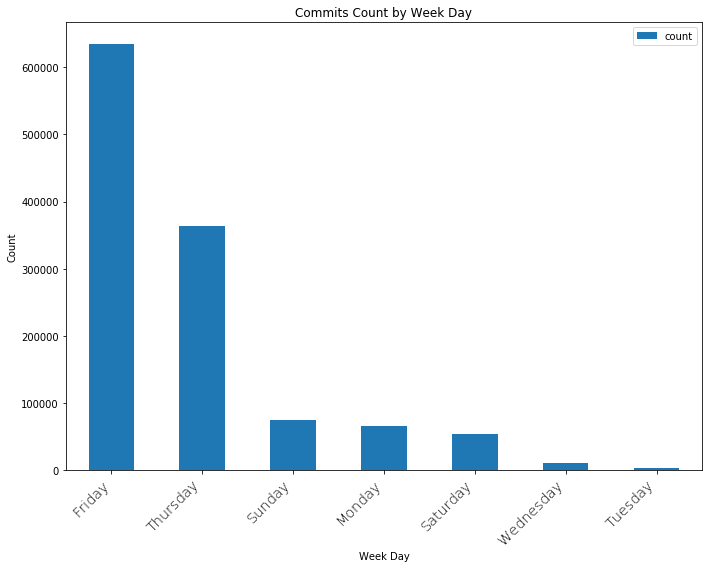

In [12]:
weekday_df = df_final.groupBy(["weekday"]).count().sort("count",ascending=False)
ax=weekday_df.toPandas().plot.bar(x='weekday',figsize=(10, 8),title="Commits Count by Week Day");
plt.xticks(rotation=45,horizontalalignment='right',fontweight='light',fontsize='x-large')
_=ax.set_xlabel('Week Day')
_=ax.set_ylabel('Count')
plt.tight_layout()

### 5.2 Top 10 committer
* #### This visulization shows top 10 committers by total commit count

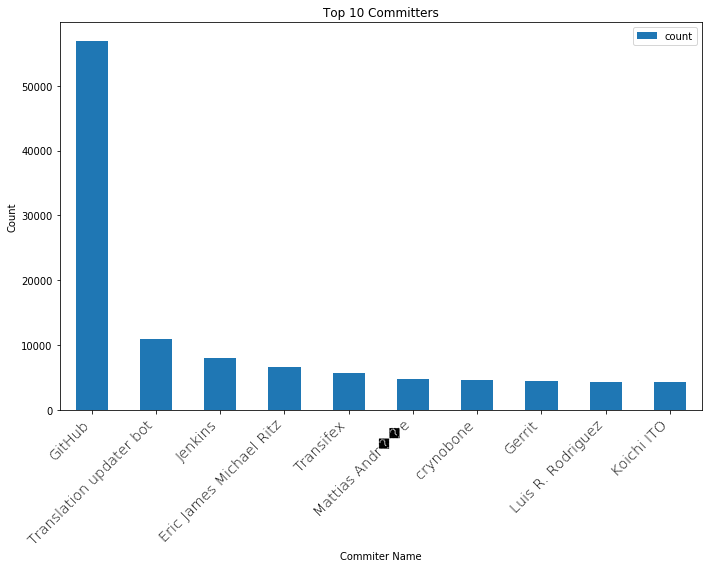

In [13]:

%matplotlib inline

cname_f_df = df_final.groupBy("cname_f").count().sort("count",ascending=False).limit(10)
ax=cname_f_df.toPandas().plot.bar(x='cname_f',figsize=(10,8),title="Top 10 Committers");
plt.xticks(rotation=45,horizontalalignment='right',fontweight='light',fontsize='x-large')
_=ax.set_xlabel('Commiter Name')
_=ax.set_ylabel('Count')
plt.tight_layout()

### 5.3 Top 10 repositories
* #### This visulization shows top 10 repositories by total commit count

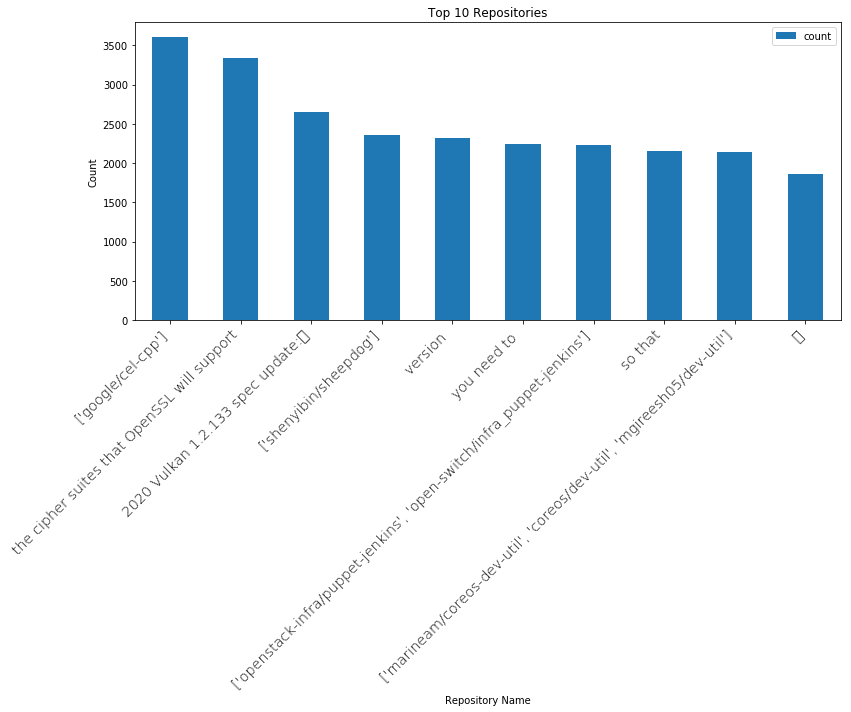

In [14]:
repo_name_f_df = df_final.groupBy("repo_name_f").count().sort("count",ascending=False).limit(10)
ax=repo_name_f_df.toPandas().plot.bar(x='repo_name_f',figsize=(12,10),title="Top 10 Repositories");
plt.xticks(rotation=45,horizontalalignment='right',fontweight='light',fontsize='x-large')
_=ax.set_xlabel('Repository Name')
_=ax.set_ylabel('Count')
plt.tight_layout()

### 5.4 20 Most used and Least used Languages
* #### From lanugagest table these are most used 20 languages and total size of codes written in that language
* #### It shows C is the most used language with total code of approx 6000 giga bytes.

There are total 400 number of programming language on github open source.


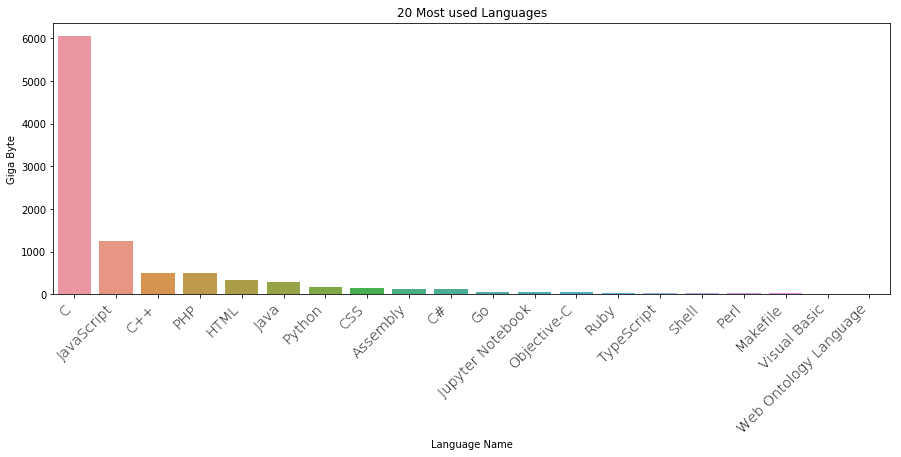

In [15]:
df_size = df1.groupby(['name']).sum().reset_index()
df_size_top_20 = df_size.sort_values('bytes', ascending=False).head(20)
df_size_top_20['Giga byte'] = df_size_top_20['bytes']/1000000000
df_size_top_20.round(2)

plt.figure(figsize=(15,5))
ax=sns.barplot('name','Giga byte', data=df_size_top_20)
plt.xticks(rotation=45,horizontalalignment='right',fontweight='light',fontsize='x-large')
_=ax.set_xlabel('Language Name')
_=ax.set_ylabel('Giga Byte')
_=ax.set_title('20 Most used Languages')
print(f"There are total {df_size['name'].count()} number of programming language on github open source." )


* #### From lanugagest table these are least used 20 languages and total size of codes written in that language
* #### It shows wollok is the least used language with total code of only 01 kilo bytes.

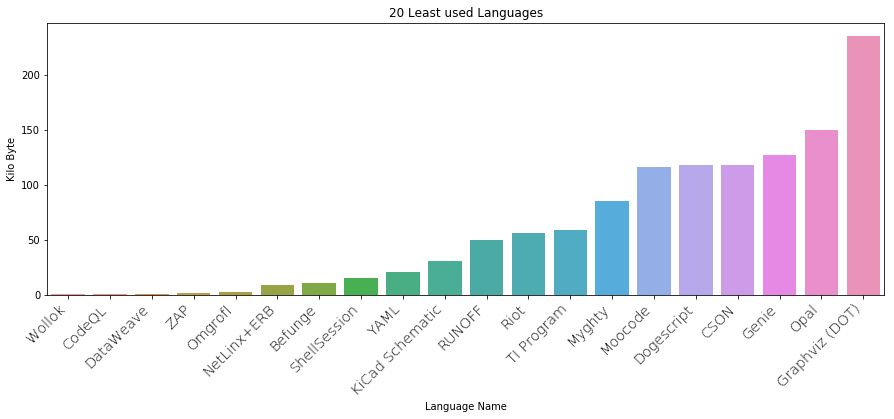

In [16]:
df_size_last_20 = df_size.sort_values('bytes', ascending=True).head(20)
df_size_last_20['Kilo byte'] = df_size_last_20['bytes']/1000
df_size_last_20.round(2)

plt.figure(figsize=(15,5))
ax=sns.barplot('name','Kilo byte', data=df_size_last_20)
plt.xticks(rotation=45,horizontalalignment='right',fontweight='light',fontsize='x-large')
_=ax.set_xlabel('Language Name')
_=ax.set_ylabel('Kilo Byte')
_=ax.set_title('20 Least used Languages')
# fig_2 = px.bar(df_size_last_20, x='name', y='Kilo byte')
plt.show()

* #### From licenses table these are most used 20 licenses and repository name

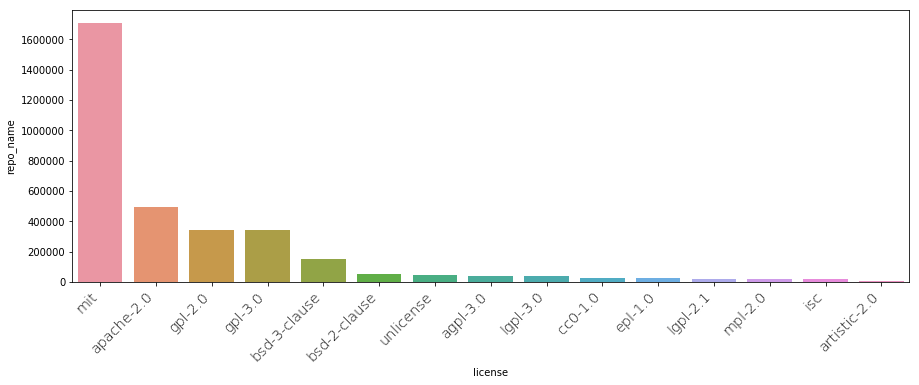

In [17]:
df_num_lic = df2.groupby(['license']).count().reset_index()
df_num_lic = df_num_lic.sort_values('repo_name', ascending=False)

plt.figure(figsize=(15,5))
sns.barplot('license','repo_name', data=df_num_lic)
plt.xticks(rotation=45,horizontalalignment='right',fontweight='light',fontsize='x-large')
_=ax.set_xlabel('License')
_=ax.set_ylabel('Repo Name')
_=ax.set_title('Top 20 licenses')
# fig_5 = px.bar(df_num_lic, x='license', y='repo_name')
plt.show()

## Part 6 Machine Learning
---
### Our main objective of this part is to check if we can create a model that can predict the conflict or other important trailer key even before the code is committed just by analyzing the content of the message.
---

### 6.1 - Show word cloud to identify popular word in commit message
---

#### First of all, we need to analyze which are the most frequent word used in a git commit message. We will be creating a word cloud to get an overview of the frequency of words used in the commit message. As our data set is huge we will randomly select 1000 row which can be converted to pandas. Once we have the sample in pandas data-frame we can use it to generate a word cloud.
---

In [18]:
df = df.filter("message is not null")
df = df.filter("time_sec is not null")
df = df.filter("ctime_sec is not null")
df = df.filter("key is not null")

df = df.cache()
part1_df = df
df.count()

756014

sample row count: 956


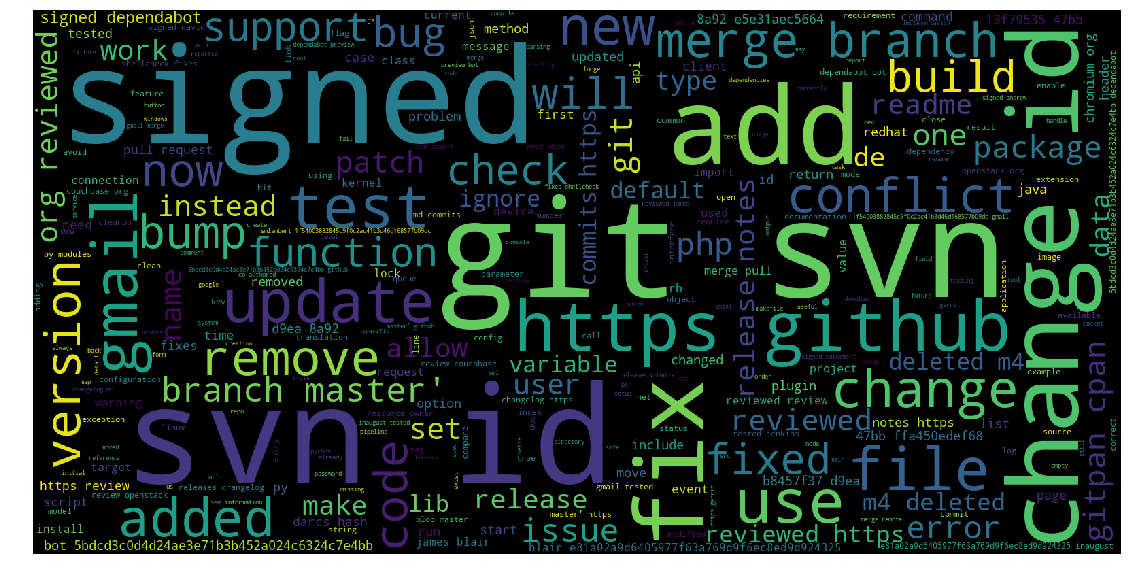

In [19]:
part3_df =df
total_rows = part3_df.count()
sample_rows = 1000
sample_df = part3_df.sample(False, sample_rows / total_rows)
print("sample row count:", sample_df.count())

# convert the spark DF to pandas DF
pdf1 = sample_df.toPandas()

words = ' '.join(pdf1.message).lower()
cloud = wordcloud.WordCloud(background_color='black',
                            max_font_size=200,
                            width=1600,
                            height=800,
                            max_words=300,
                            relative_scaling=.5).generate(words)
plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(cloud)
plt.savefig('github-commit-message-word.png')

### 6.2 - Show word count to identify popular word in message
---
#### From the world cloud, we get an overview of the frequent words but to select the top 40 words we need an exact count of all unique words. In this part, we will create a dataframe with word and its count.
---


#### 6.2.1 In this part first, we will split all unique word which is at least two characters long. To achieve this goal we will use pyspark user-defined function which can take a string as input and return an array of words. Once we have the array of words in each row we can explode it and create a new dataframe that contains one word in a row.

In [20]:
part2_df = df

@F.udf(returnType=ArrayType(StringType(), True))
def split_word(str1):
    str1 = str1.lower()
    regex = re.compile(r"[\w][\w]+", re.I) #Check for words greater than one character
    matches = regex.findall(str1)
    return matches

split_df = (part2_df.select(split_word(F.col('message')).alias('split')))

single_df = (split_df.select(explode(split_df.split).alias('word')))
single_df.show()
single_df.count()


+--------------------+
|                word|
+--------------------+
|             setting|
|              ignore|
|                tags|
|                 for|
|            contacts|
|                 git|
|                 svn|
|                  id|
|8a5e8208699cc4d52...|
|                5537|
|            fee104cc|
|                1dfa|
|                8c0f|
|                632d|
|        d3b7e6b59fb0|
|             updated|
|               tests|
|                  to|
|               match|
|             library|
+--------------------+
only showing top 20 rows



19720318

#### 6.2.2 Once we have a dataframe which contains all word in a column with one word in a row then we can count all unique words to get the frequency of each word. To get an overview we can also look at the top twenty row of the data frame after we order it by count.

In [21]:
def wordCount(wordListDF):
    return (wordListDF.groupBy('word').count())

word_count_df = wordCount(single_df)
top_word_count_df = word_count_df.orderBy("count", ascending=0)
top_word_count_df = top_word_count_df.cache()
top_word_count_df.show()
top_word_count_df.count()

+------+------+
|  word| count|
+------+------+
|    by|452438|
|   com|417535|
|   the|395741|
|    to|386083|
|    id|346870|
|   off|295971|
|signed|293978|
|   git|247688|
|   svn|231227|
|   for|177667|
|   and|169093|
|    of|168420|
|    in|166207|
| https|126120|
|change|125339|
|  from|119357|
|   add|110697|
|github|107629|
|    is|107434|
|    on|102282|
+------+------+
only showing top 20 rows



575977

#### 6.2.3 We will plot the top 20 words and its count to understand which words are most important in the commit message.

<function matplotlib.pyplot.show(*args, **kw)>

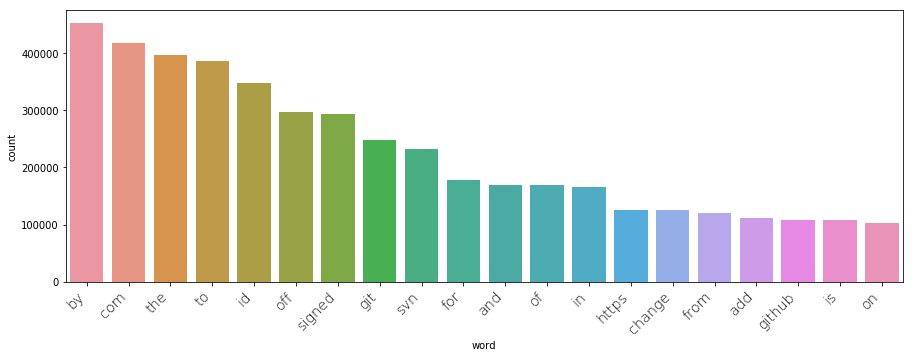

In [22]:
pdf_2 = top_word_count_df.limit(20).toPandas()
plt.figure(figsize=(15,5))
sns.barplot('word','count', data=pdf_2)
plt.xticks(rotation=45,horizontalalignment='right',fontweight='light',fontsize='x-large')
plt.show

### 6.3 - Get the list of popular 40 words in message
---
#### We need to finalize the top 40 words in the commit message which will be the basis of our analysis. Now we already have a dataframe that contains all unique words and its count so we can simply select the top 40 words by count.
---

In [23]:
test = top_word_count_df.head(40)
List_of_valid_words = []
for x in test:
    List_of_valid_words.append(x.word)
print(List_of_valid_words)

['by', 'com', 'the', 'to', 'id', 'off', 'signed', 'git', 'svn', 'for', 'and', 'of', 'in', 'https', 'change', 'from', 'add', 'github', 'is', 'on', 'org', 'reviewed', 'this', 'gmail', 'fix', 'it', 'with', 'merge', 'added', '0410', 'that', 'not', 'branch', 'use', 'test', 'be', 'conflicts', 'update', 'master', 'http']


### 6.4 - Show word count to identify popular word in trailer key

#### 6.4.1 Now we need to analyze the trailer key available in the dataset. We will first group the row by trailer key and then count all unique keys.

In [24]:
part4_df = df

word_count_df_key = part4_df.groupBy('key').count()
top_word_count_df_key = word_count_df_key.orderBy("count", ascending=0)
top_word_count_df_key = top_word_count_df_key.cache()
top_word_count_df_key.show()
top_word_count_df_key.count()

+-----------------+------+
|              key| count|
+-----------------+------+
|    Signed-off-by|249674|
|       git-svn-id|230059|
|        Change-Id| 62669|
|        Conflicts| 50018|
|      Reviewed-by| 16418|
|            https| 14999|
|       darcs-hash| 11197|
|             http|  8907|
|      Reviewed-on|  7557|
|        Tested-by|  7518|
|  Transmitted-via|  6785|
|   Co-authored-by|  3762|
|         modified|  2536|
|             TODO|  2220|
|         Acked-by|  2170|
|PiperOrigin-RevId|  1922|
| Former-commit-id|  1764|
|            Fixes|  1412|
|             Note|  1218|
|              Bug|  1160|
+-----------------+------+
only showing top 20 rows



10284

#### 6.4.2 We will create a bar chart of top 20 trailer key to analyze its frequency.

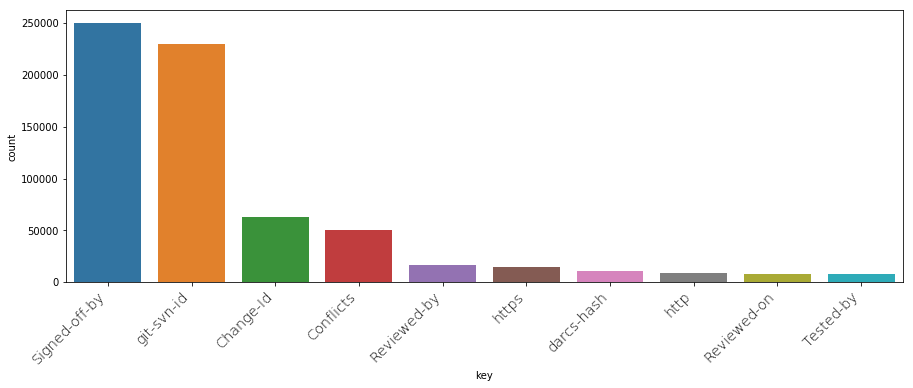

In [25]:
pdf_4 = top_word_count_df_key.limit(10).toPandas()
plt.figure(figsize=(15,5))
sns.barplot('key','count', data=pdf_4)
plt.xticks(rotation=45,horizontalalignment='right',fontweight='light',fontsize='x-large')
plt.show()

#### 6.4.3 After analysisi of the top 40 trailer key we select the most interesting words in the top 40 trailer key. No we choose 'signed', 'git','change','conflicts', 'reviewed', 'http' and  'tested' for analysis.

In [26]:
top_40 = top_word_count_df_key.head(40)
List_of_valid_words_key = []
for x in top_40:
    List_of_valid_words_key.append(x.key)
print(List_of_valid_words_key)
List_of_interest_key = ['signed', 'git','change','conflicts', 'reviewed', 'http', 'tested' ]

['Signed-off-by', 'git-svn-id', 'Change-Id', 'Conflicts', 'Reviewed-by', 'https', 'darcs-hash', 'http', 'Reviewed-on', 'Tested-by', 'Transmitted-via', 'Co-authored-by', 'modified', 'TODO', 'Acked-by', 'PiperOrigin-RevId', 'Former-commit-id', 'Fixes', 'Note', 'Bug', 'RevBy', 'Approved', 'BUG', 'Reported-by', 'REVIEW', 'See', 'Fix', 'Details', 'git-subtree-split', 'fix', 'git-subtree-dir', 'Closes-Bug', 'Co-Authored-By', 'Author', 'gitpan-cpan-distribution', 'gitpan-cpan-maturity', 'gitpan-cpan-path', 'gitpan-cpan-author', 'gitpan-cpan-version', 'Added']


### 6.5 - Create new data frame with popular word count as column

#### 6.5.1 Now we have decided which 40 words we want to do the analysis so now we will create an array of 40 items for each row which will represent the count of the word. We will use this array as a feature in our machine learning algorithm.

In [27]:
df_part5 = df
list_col = List_of_valid_words
list_word  = List_of_interest_key

@F.udf(returnType=ArrayType(StringType(), True))
def split_word_count(str1):
    list1=[]
    for i, item in enumerate(list_col):
        str1 = str1.lower()
        regex = re.compile(item, re.I)
        matches = regex.findall(str1)
        count =len(matches)
        list1.append(count)
    return list1
df_part5 = df_part5.withColumn("wordcountarray", split_word_count(F.col("message") ))



#### 6.5.2 We have also decided on the trailer key we are interested in so now we can create a target column that will contain the trailer key number instead of the word. As we also know that the trailer key is singular so we can be sure that it will contain only one from our list of interesting trailer keys.

In [28]:
list_word  = List_of_interest_key
@F.udf(returnType=IntegerType())
def search_word(str1):
    value = len(list_word)
    for i,item in enumerate(list_word):
        if bool(re.search(item, str1, re.I)) :
            value= i
            break
    return value
df_part5 = df_part5.withColumn("target", search_word(F.col("key")))


#### 6.5.3 We will also add the total number of words in a commit message and use it for a machine learning algorithm if it improves the model.

In [29]:
@F.udf(returnType=IntegerType())
def word_count(str1):
    str1 = str1.lower()
    regex = re.compile(r"[\w][\w]+", re.I) #Check for words greater than one character
    matches = regex.findall(str1)
    return len(matches)
df_part5 = df_part5.withColumn("wordcount", word_count(F.col("message") ))

### 6.6 - Prepare Data for Machine Learning

#### 6.6.1 First, we need to convert the wordcount feature into vector.dense because VectorAssembler doesn't allow Array datatype. Then we will merge all the features into a single vector of features. I tried with other parameters like 'time_sec', 'ctime_sec' and 'wordcount' but it improves the prediction by 0.02% only so I decided to keep only the word count feature and not the other data we prepared so far.

In [30]:
#Convert String Array to vector
list_to_vector = udf(lambda l: Vectors.dense(l), VectorUDT())
df_part6 = df_part5.select(
    df_part5["time_sec"], 
    df_part5["ctime_sec"],
    list_to_vector(df_part5["wordcountarray"]).alias("wordcountarray"),
    df_part5["target"],
    df_part5['wordcount']
)
# Including 'time_sec' and  'ctime_sec' increase the accuracy by only 0.2% so we exclude it keep model simple.
features = [ 'wordcountarray'] 
assembler = VectorAssembler(inputCols=features, outputCol="features")
ml_df6 = assembler.transform(df_part6)
ml_df6.select("features", "target").show(truncate=False)

+----------------------------------------------------------------------------------------+------+
|features                                                                                |target|
+----------------------------------------------------------------------------------------+------+
|(40,[4,7,8,9,12,19,25],[1.0,1.0,1.0,1.0,1.0,1.0,1.0])                                   |1     |
|(40,[1,3,4,7,8,13,17,25,29,34,37,39],[1.0,2.0,1.0,2.0,1.0,1.0,1.0,5.0,1.0,3.0,2.0,1.0]) |1     |
|(40,[2,4,7,8,9,12,19,25,32],[1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0])                      |1     |
|(40,[4,7,8,16,25],[1.0,1.0,1.0,1.0,1.0])                                                |1     |
|(40,[4,7,8,12,25],[1.0,1.0,2.0,1.0,1.0])                                                |1     |
|(40,[4,7,8,25],[1.0,1.0,1.0,1.0])                                                       |1     |
|(40,[0,4,7,8,25],[1.0,1.0,1.0,1.0,1.0])                                                 |1     |
|(40,[3,4,7,8,19,25,

#### 6.6.2 To use the cluster efficiently we have to make sure we have the number of partitions equal to or more than the number of available core. We will check the number of available partition and if it is less than the number of available core we will repartition the data.

In [31]:
# Adjust repartitioning to match utilize the available core
print("Partitions before:", ml_df6.rdd.getNumPartitions())
if ml_df6.rdd.getNumPartitions() == 10:
    print("Skip partition as we already have desired partition")
else:    
    ml_df6 = ml_df6.repartition(10).cache()
    _ = ml_df6.count()
    print("Partitions after:", ml_df6.rdd.getNumPartitions())

Partitions before: 10
Skip partition as we already have desired partition


### 6.7- Train Machine Learning Model
---
#### Now we have the data prepared for machine learnig. We will be using RandomForestClassifier with numTrees =10 because it gives us the best result. We tried other regression techniqu but Random Forest fits the data perfectly.
---

In [32]:
%%time

# Load and parse the data file, converting it to a DataFrame.
data = ml_df6

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="target", outputCol="indexedLabel").fit(data)

# Automatically identify categorical features, and index them.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(data)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)



CPU times: user 108 ms, sys: 17.4 ms, total: 125 ms
Wall time: 15min 30s


### 6.8- Evaluate the model
---
#### As we have distributed the dataset into 70% for training and 30% for testing we can use the test data to evaulate the performance of our model by comparing the actual and predicted label.
---

In [33]:
%%time

# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.select("predictedLabel", "target", "features").show(5)

+--------------+------+--------------------+
|predictedLabel|target|            features|
+--------------+------+--------------------+
|             0|     7|(40,[0,1,4,5,6,11...|
|             1|     1|(40,[2,4,7,8,12,1...|
|             7|     7|(40,[2,3,5,11,12,...|
|             7|     7|(40,[4,9,10,12,16...|
|             7|     7|(40,[3,12,16,18,1...|
+--------------+------+--------------------+
only showing top 5 rows

CPU times: user 31.6 ms, sys: 6.57 ms, total: 38.2 ms
Wall time: 1min 50s


In [34]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))
print("Accuracy = %g" % ( accuracy))

rfModel = model.stages[2]
print(rfModel)  # summary only

Test Error = 0.119481
Accuracy = 0.880519
RandomForestClassificationModel (uid=RandomForestClassifier_3e9d6a9ba4e6) with 10 trees


### 6.9- Overview of the trailer key in our dataset.

#### 6.9.1 Count of trailer key in dataset.

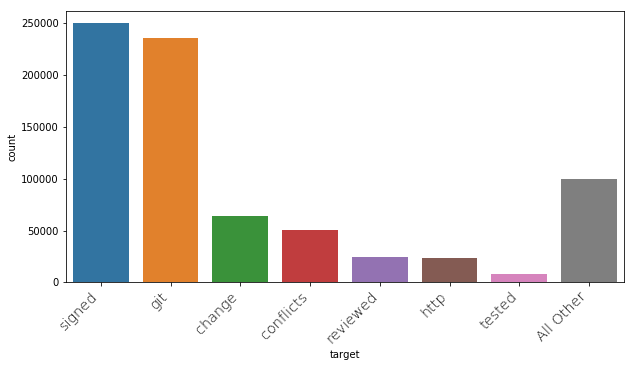

In [35]:
%matplotlib inline

target_group_df91  = df_part5.groupBy('target').count()
target_group_df91 = target_group_df91.orderBy("target")
pdf91 = target_group_df91.toPandas()
pdf91['target'] = List_of_interest_key + ['All Other']
plt.figure(figsize=(10,5))
sns.barplot('target','count', data=pdf91)
plt.xticks(rotation=45,horizontalalignment='right',fontweight='light',fontsize='x-large')
plt.show()

#### 6.9.2 Count of trailer key with wrong prediction.

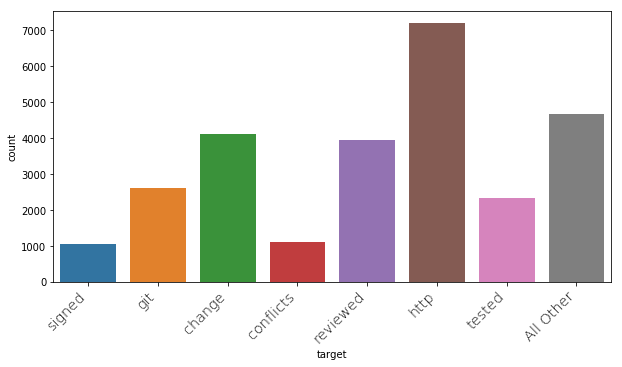

In [36]:
%matplotlib inline
df_part_9 = predictions.filter(predictions.predictedLabel != predictions.target)

target_group_df92  = df_part_9.groupBy('target').count()
target_group_df92 = target_group_df92.orderBy("target")

pdf92 = target_group_df92.toPandas()
pdf92['target'] = List_of_interest_key + ['All Other']
plt.figure(figsize=(10,5))
sns.barplot('target','count', data=pdf92)
plt.xticks(rotation=45,horizontalalignment='right',fontweight='light',fontsize='x-large')
plt.show()

## Conclusion:


* ### The highest number of commits are being performed on Fridays and the lowest number of commits are being performed on Tuesdays.
* ### C is the most used language with code size of approx 6000 Gigabytes and Wollok is least used language with code of only 01 kilobyte.
* ### One of the most used license is mit.
* ### By analyzing the text of comment we can predict the trailer key with around 89% accuracy.


## Future Prospect:
---
### There are two interesting table file and content which can be used for future analysis. Using this table we can get an overview of what content people are committing and what kind of challenges are faced for different programming languages. This will require more time and commitment but it will definitely provide an interesting insight into opensource development.
---

## References:
---
### [1] https://cloud.google.com/blog/products/gcp/github-on-bigquery-analyze-all-the-open-source-code
### [2] https://spark.apache.org/docs/latest/ml-classification-regression.html#random-forest-classifier
### [3] https://pypi.org/project/google-cloud-bigquery/
### [4] https://talc.ucalgary.ca/
---